## Witnessing two-copy six-qubit GME activation.

### Summary:

* This notebook show witnessing of two-copy activation of GME.
* The states were prepared by mixing several constituent mixed states with some weight. 
* The witness value was measured by a series of Pauli-strings measurements defined by a previously defined table performed on each constituent state and then by post-processing the resulting tomograms.
* The resulting experimental two-copy witness value was $-(5.9 \pm 0.5)\cdot 10^{-3}$.
* Full tomography of a single copy has been used to reconstruct the state and then find an optimal GME witness using PSD program. The single-copy witness value was positive, meaning that the single copy was non-GME.

### State preparation

- **a1:** $|+\rangle_2 \otimes |\Phi^+\rangle_{10}$
- **a2:** $|-\rangle_2 \otimes |\Phi^-\rangle_{10}$
- **a3:** $\hat{U} \left(|+\rangle_2 \otimes |\Phi^+\rangle_{10}\right)$
- **a4:** $\hat{U} \left(|-\rangle_2 \otimes |\Phi^-\rangle_{10}\right)$
- **b1:** $|\Phi_{02}^+\rangle \otimes |+\rangle_1$
- **b2:** $|\Phi_{02}^-\rangle \otimes |-\rangle_1$
- **b3:** $\hat{U}\left(|\Phi_{02}^+\rangle \otimes |+\rangle_1\right)$
- **b4:** $\hat{U}\left(|\Phi_{02}^-\rangle \otimes |-\rangle_1\right)$
- **c1:** $|001\rangle_{210}$
- **c2:** $|110\rangle_{210}$

where: 
- $U = \hat{S} \otimes \hat{S} \otimes \hat{Z}$
- $|\Phi^\pm\rangle_{10} = |00\rangle_{10} \pm |11\rangle_{10}$
- $|\Phi^\pm\rangle_{20} = |00\rangle_{20} \pm |11\rangle_{20}$

States are mixed with mixing factor $q$ such that states `a1` to `b4` have weight $(1-q)/8$ and states `c1` and `c2` have weight $q/2$.

### Comment on un/packing the witness table.

The first 16 lines of the witness table contains measurements like `ZZZZII`. These measurements always constist of `I` or `Z`. Therefore they can me measured using a a single setting: `ZZZZZZ`. To obtain expectation value for e.g. `ZZZZII`, one just needs to sum the outcome probabilities multiplied by suitable factors. Obtaining the factors is handled by `get_walsh_hadamard_vec()` function.

**Example:**

Let us measure in `ZZ` basis, with outcomes $\vec{p} = (p_{00}, \dots, p_{11})$. The auxiliary vector to get expectation value `IZ` is $\vec{w}_{IZ} = (1, -1, 1, -1)$, and the expectation value is 
$\vec{w}_{IZ} \cdot \vec{p}$. For expectation value `ZZ`, the vector would be $\vec{w}_{ZZ} = (1, -1, -1, 1)$. This vector is constructed as an flattened cartesian product of eigenvalue vectors corresponding to the operators in the measurement string.

To be more rigorous, one should measure in `ZZZZZZ` settings 16 times independently. But I think this a reasonable/justified simplification.

## Part 1 - imports and definitions

In [1]:
# Import packages

#builtins
import itertools
from functools import reduce, cache

#essentials
import numpy as np
import matplotlib.pyplot as plt
import h5py #to open data packs

#non-essentials
from tqdm.notebook import tqdm # to show progressbars

In [2]:
# Quantum mechanics helper functions and constants
# This has been in KetSugar.py, but it is moved here 
# for transparency.
# ------------------------------------

LO = np.array([[1],[0]])
HI = np.array([[0],[1]])
HLO = (LO+HI)*(2**-.5)
HHI = (LO-HI)*(2**-.5)
CLO = (LO+1j*HI)*(2**-.5)
CHI = (LO-1j*HI)*(2**-.5)

Sgate = np.array([[1, 0], [0, 1j]])
SI = np.eye(2)
SZ = np.diag([1,-1])
SX = np.array([[0,1],[1,0]])
SY = np.array([[0,-1j],[1j,0]])

#eigenvectors and eigenvalues of Pauli matrices
PAULI_EIGENBASE_DICT = {
    'I' : ((LO, HI), (1,1)),
    'X' : ((HLO, HHI), (1,-1)),
    'Y' : ((CLO, CHI),(1,-1)),
    'Z' : ((LO, HI), (1,-1)),
}

def dagger(x : np.ndarray) -> np.ndarray:
    """
    Hermite conjugation of x.
    """
    return x.T.conjugate()

def ketbra(x : np.ndarray, y : np.ndarray) -> np.ndarray:
    """
    Outer product of two ket-vectors -> C-matrix
    """
    return np.dot(x, y.T.conjugate())

def kron(*arrays) -> np.ndarray:
    """
    Multiple Kronecker (tensor) product.
    Multiplication is performed from left.    
    """
    E = np.eye(1, dtype=complex)
    for M in arrays:
        E = np.kron(E,M)
    return E

def BinKet(i : int = 0,imx : int =1) -> np.ndarray:
    """
    Computational base states i in imx+1-dimensional vectors.
    """
    ket = np.zeros((imx+1,1), dtype=complex)
    ket[i] = 1
    return ket

def ApplyOp(Rho : np.ndarray,M : np.ndarray) -> np.ndarray:
    """
    Calculate M.Rho.dagger(M).
    """
    return M @ Rho @ M.T.conjugate()

def ExpectationValue(Ket : np.ndarray, M : np.ndarray) -> np.ndarray:
    """
    Expectation value <bra|M|ket>.
    """
    return (Ket.T.conjugate() @ M @ Ket)[0,0]

@cache
def get_walsh_hadamard_vec(label : str) -> np.ndarray:
    """
    Get auxiliary vector for turning tomogram row into expectation value. Candidate for tabellation.
    """
    #eigenvalues of Pauli operators
    arr_map = {
        'X' : np.array([1,-1]),
        'Y' : np.array([1,-1]),
        'Z' : np.array([1,-1]),
        'I' : np.array([1,1])
    }
    return reduce(np.outer, [arr_map.get(c, np.eye(1)) for c in label]).ravel()
get_walsh_hadamard_vec.cache_clear()

@cache #cache calls to r
def base_string_to_proj(string : str) -> list:
    """
    Input measurement string and get projection operators corresponding to that string, 
    all combinations that can happen.    
    """    
    eigenvects = [PAULI_EIGENBASE_DICT[b][0] for b in string]
    proj_kets = [kron(*vecs) for i, vecs in enumerate(itertools.product(*eigenvects))]
    return proj_kets
base_string_to_proj.cache_clear()

def get_probabilities(rho : np.ndarray, base_str : str) -> np.ndarray:
    """Input density matrix and measurement string, and get array of probabilities ordered from 0..0 to 1..1"""
    #probs are ordered in increasing order of their binary representation
    probs = np.array([ExpectationValue(ket, rho).real for ket in base_string_to_proj(base_str)])
    return probs

PAULI_BASE_DICT = {
    'I' : SI,
    'X' : SX,
    'Y' : SY,
    'Z' : SZ
}
def base_string_to_op(string : str) -> list:
    """
    Input measurement string and get projection operators corresponding to that string, 
    all combinations that can happen.    
    """    
    eigenvects = [PAULI_BASE_DICT[b] for b in string]
    proj_kets = kron(*eigenvects)
    return proj_kets


In [3]:
# Define the states considered here
# ---------------------------
#Swap gates
def swap_ij(n : int, i : int, j : int) -> np.ndarray:
    """Generate swap matrix of qubits i,j in n-qubit space."""
    left_qubits = i
    central_qubits = (j - i) - 1
    right_qubits = (n - j) - 1
    eye_left = np.eye(1 << left_qubits)
    eye_center = np.eye(1 << central_qubits)
    eye_right = np.eye(1 << right_qubits)    
    ket_01 = kron(eye_left, LO, eye_center, HI, eye_right)
    ket_10 = kron(eye_left, HI, eye_center, LO, eye_right)
    bra_01 = dagger(ket_01)
    bra_10 = dagger(ket_10)
    swap = np.eye(1 << n, dtype=complex) \
        - ket_01 @ bra_01 - ket_10 @ bra_10 \
        + ket_01 @ bra_10 + ket_10 @ bra_01
    return swap

#operator that does this swap: abcabc -> aabbcc
swap_abc = swap_ij(6,3,4) @ swap_ij(6,1,2) @ swap_ij(6,2,3)

prep_gate = kron(Sgate, Sgate, SZ)
bellp = (BinKet(0b00, 3) + BinKet(0b11, 3))/np.sqrt(2)
bellm = (BinKet(0b00, 3) - BinKet(0b11, 3))/np.sqrt(2)
bell02p = (BinKet(0b000, 7) + BinKet(0b101, 7)+BinKet(0b010, 7) + BinKet(0b111, 7))/2
bell02m = (BinKet(0b000, 7) - BinKet(0b101, 7)-BinKet(0b010, 7) + BinKet(0b111, 7))/2

#single-copy constituent states as ket vectors
theo_kets_3q = {
    'a1' : kron(HLO, bellp),
    'a2' : kron(HHI, bellm),
    'a3' : prep_gate @ kron(HLO, bellp),
    'a4' : prep_gate @ kron(HHI, bellm),
    'b1' : bell02p,
    'b2' : bell02m,
    'b3' : prep_gate @ bell02p,
    'b4' : prep_gate @ bell02m,
    'c1' : BinKet(0b001, 7),
    'c2' : BinKet(0b110, 7)
}

#single-copy constituent states as density matrices
theo_rhos_3q = {key : ketbra(ket, ket) for key, ket in theo_kets_3q.items()}
theo_kets_6q = {
    f'{key1},{key2}' :
    kron(theo_kets_3q.get(key2), theo_kets_3q.get(key1)) 
    for key1, key2 in itertools.product(theo_kets_3q.keys(), repeat=2)}

#two-copy constituent states
theo_rhos_6q = {key : ketbra(ket, ket) for key, ket in theo_kets_6q.items()}
theo_rhos_6q_swapped = {key : ApplyOp(rho, swap_abc) for key, rho in theo_rhos_6q.items()}

key_order = list(theo_rhos_6q_swapped.keys())

Q = 0.06
weights_single_copy = np.array([(1-Q)/8]*8 + [Q/2]*2)

weights_two_copy = np.outer(weights_single_copy,weights_single_copy).ravel()
# # equivalent to
# def key_to_weight(key):
#     n = key.count('c')
#     if n==0:
#         return ((1-Q)**2)/64
#     if n==1:
#         return ((1-Q)*Q)/(8*2)
#     if n==2:
#         return Q*Q/4

### Load measurement table 


In [ ]:
with h5py.File('data/two-copy-witness.h5', 'r') as h5f:
    witness_measurements = [s.decode('ascii') for s in h5f['two_copy_table_meas']]
    witness_full_meas = [s.decode('ascii') for s in h5f['two_copy_table_meas_full']] #h5f['two_copy_table_meas_full']
    witness_factors = np.array(h5f['two_copy_table_factors'])
    witness_op = np.array(h5f['two_copy_operator'])

#table of vectors used to convert tomogram lines to expectation values
walsh_table = np.array([get_walsh_hadamard_vec(m) for m in witness_full_meas])

def extend_tomogram(tomo : np.ndarray) -> np.ndarray:
    """
    Copy first line of the tomogram 16-times.
    This is only a helper function to make the subsequent 
    calculations more convenient.
    It will be used to predict exp. values of measurements containing only I and Z.
    """
    return np.array([tomo[0]]*16 + list(tomo[1:]))

constructed_witness = sum([base_string_to_op(code)*w for code, w in zip(witness_full_meas, witness_factors)])
constructed_witness /= np.trace(constructed_witness.real)

## Part 2 - Load and process measured data

In [5]:
def process_tomograms(tomos : np.ndarray) -> float:
    """
    Take a pack of tomograms and turn them into a witness value.
    Args:
        tomos (np.ndarray): Array of measured tomograms with shape (100, 17, 64),
            where 100 is the number of constituent two-copy states,
            17 is the number of measurement settings,
            and 64 is the number of outcomes per setting.
    Returns:
        float: The computed witness value from the weighted tomograms.
    """
    #weight-and-mix the constituent tomograms
    weighted_tomo_counts = np.sum(tomos * weights_two_copy.reshape((100,1,1)), axis=0)
    #norm lines to identity sum - in order to convert possible count array to probabilities
    weighted_tomo_probs = weighted_tomo_counts/np.sum(weighted_tomo_counts, axis=1).reshape((17,1))
    #extend tomogram by copying the first line 16-times to...
    wtomo = extend_tomogram(weighted_tomo_probs)
    #...calculate expectation values
    expvals = np.sum(wtomo * walsh_table, axis=1)
    #turn expvals into subwitnesses and ensure trace(W)=1 (the factor 1/64)
    return (expvals @ witness_factors)/64

def process_tomograms_expvals(tomos : np.ndarray) -> np.ndarray:
    """
    Take a pack of tomograms and turn them into a witness value.
    Args:
        tomos (np.ndarray): Array of measured tomograms with shape (100, 17, 64),
            where 100 is the number of constituent two-copy states,
            17 is the number of measurement settings,
            and 64 is the number of outcomes per setting.
    Returns:
        ndarray: expectation value for each line of tomogram, for all subtomograms
    """
    ntomo = tomos/(np.sum(tomos, axis=2).reshape((100,17,1)))
    expvals = np.sum(ntomo * walsh_table[-1].reshape((1,1,64)), axis=2)
    return expvals



In [6]:
# I resaved the original numpy array as H5 file
# to avoid potentially untrusted pickling and ensure
# that I can open the file on all my machines
# I also added some metadata
with h5py.File('data/wit_data_27_05_25_Block2.h5', 'r') as h5f:
    measd_keys = h5f.attrs.get('prepared_states')
    #load H5 file into dict of tomograms
    measd_tomogram = {key : np.array(h5f[key]) for key in key_order}

#pack dict into array for easier processing
measd_tomogram_arr = np.array([measd_tomogram[key] for key in key_order])

#extract witness value
wval = process_tomograms(measd_tomogram_arr)
print(f'wval = {wval:.3e}')

wval = -5.698e-03


In [7]:
# test processing function on theoretical state
# theo_rhos_6q_swapped
gen = (get_probabilities(r, m) for (key, r) in tqdm(theo_rhos_6q_swapped.items()) for m in witness_measurements)
theoretical_tomogram = np.array(list(gen)).reshape((100,17,64))

wval_th = process_tomograms(theoretical_tomogram)
print(f'wval = {wval_th:.3e}')

#for consistency, check also theoretical density matrix
rho_tot_th = sum((r*w for (key, r), w in zip(theo_rhos_6q_swapped.items(), weights_two_copy)))
wval_th_ref = np.trace(constructed_witness @ rho_tot_th).real
print(f'wval_ref = {wval_th_ref:.3e}')

  0%|          | 0/100 [00:00<?, ?it/s]

wval = -8.904e-03
wval_ref = -8.904e-03


### Analysis of statistical significance

We do it by resamampling the tomogram lines using multinomial distribution.

**Assumptions:**
* 50 shots per state and setting
* We simulate the measurement process, i.e. every constituent is sampled using 50 shots, regardless its corresponding weight in the mixture.


In [8]:
#fix RNG for reproducibility
RNG = np.random.default_rng(seed=20250529)
# Number of Monte Carlo samples per SNR
MONTE_CARLO_SAMPLES = 1000  
#number of shots in the original dataset
SHOTS = 50 

#renorm tomogram, to get rid of small numerical errors of oveflowing 1 in prob. sub
n_measd_tomogram_arr = measd_tomogram_arr/measd_tomogram_arr.sum(axis=2).reshape((100,17,1))

print("Generating samples...")
sampled_tomograms = RNG.multinomial(SHOTS, n_measd_tomogram_arr, (MONTE_CARLO_SAMPLES, 100, 17))
print("Processing samples...")
sampled_witness_values = np.array([process_tomograms(tomo) for tomo in tqdm(sampled_tomograms)])


Generating samples...
Processing samples...


  0%|          | 0/1000 [00:00<?, ?it/s]

11.6
max -0.004208936197916664
min -0.007388506510416665
sampled mean -0.005702134268229166
seed value -0.005698220052083329
sampled std 0.0004900384004714582
Fraction of positive values: 0.0


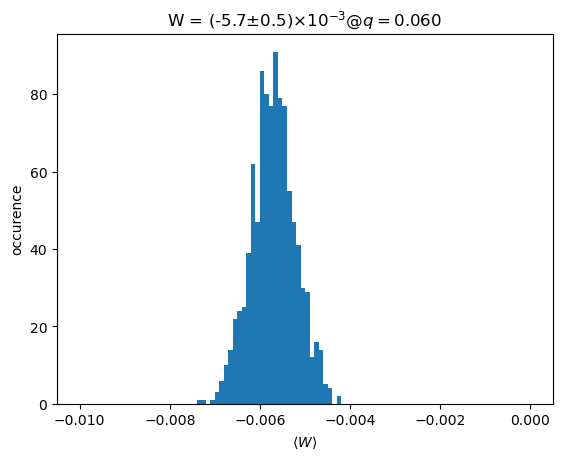

In [9]:
seed = process_tomograms(n_measd_tomogram_arr)
sigma = np.std(sampled_witness_values)
mu = np.mean(sampled_witness_values)
significance = seed/sigma
portion_above_zero = np.sum(sampled_witness_values >= 0)

print(f'{abs(significance):.1f}')
print('max', np.max(sampled_witness_values))
print('min', np.min(sampled_witness_values))
print('sampled mean', mu)
print('seed value', seed)
print('sampled std', sigma)
print('Fraction of positive values:', portion_above_zero/MONTE_CARLO_SAMPLES)

#Plot histogram
plt.hist(sampled_witness_values, bins=np.linspace(-0.01, 0, 101))
plt.title(f'W = ({seed*1000:.1f}$\pm${sigma*1000:.1f})$\\times 10^{{-3}} @ q=${Q:.3f}')
plt.xlabel('$\\langle W \\rangle$')
plt.ylabel('occurence')
plt.show()

## Part 3 - Check that single-copy state is non-GME

- Here we searched for single-copy three-qubit optimal GME witness. None of the Monte Carlo samples had a negative value for the found optimal witness. However, unsuccessfull search for such a witness does not necessarily mean that the target state is biseparable, although if the state is biseparable, the search can't succeed.
- Please refer to `check_biseparability.py` for the use of dedicated algorithm for biseparability checking.

## Part 4 - Detailed comparison of measured tomograms to the theory

Text(0.5, 1.0, 'MAE')

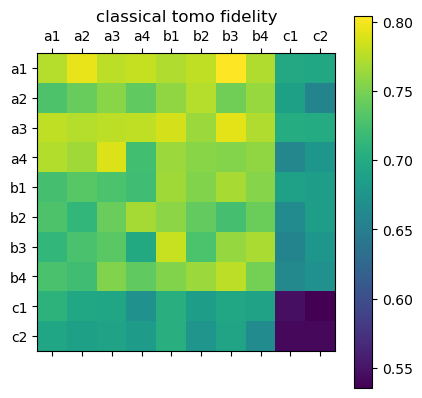

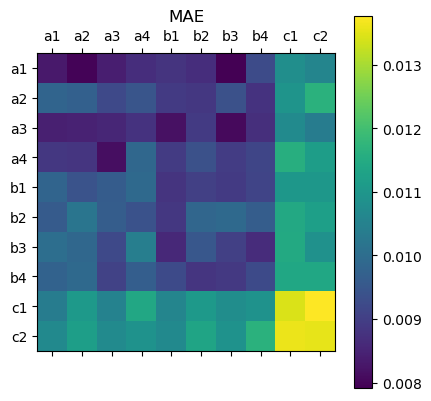

In [30]:
def mae(a,b):
    """
    Mean absolute error of two arrays.
    """
    return np.mean(np.abs(a.ravel()-b.ravel()))

def cl_mean_fid(a,b):
    """
    Classical fidelity mean between two tomograms. First, fidelity is calculated for each line (distribution), and then this is mean.
    """
    return np.mean(np.sum((a*b)**0.5, axis=1)**2)

clfids = []
maes = []
for i, key in enumerate(key_order):
    tomo_th = theoretical_tomogram[i]
    tomo_exp = measd_tomogram_arr[i]
    maes.append(mae(tomo_th, tomo_exp))
    clfids.append(cl_mean_fid(tomo_th, tomo_exp))
clfids = np.array(clfids).reshape((10,10))
maes = np.array(maes).reshape((10,10))

labels = [key for key in theo_kets_3q]

plt.matshow(clfids)
plt.xticks(np.arange(10), labels)
plt.yticks(np.arange(10), labels)
plt.colorbar()
plt.title('classical tomo fidelity')

plt.matshow(maes)
plt.xticks(np.arange(10), labels)
plt.yticks(np.arange(10), labels)
plt.colorbar()
plt.title('MAE')

#observation:
# `c` states have lower fidelity/higher MAE
# in most tomo lines, theoretically distribution are uniformly spread over 64 bins, 
# but we measured it using only 50 shots < # bins, so it is undersampled

0.5417481913698325

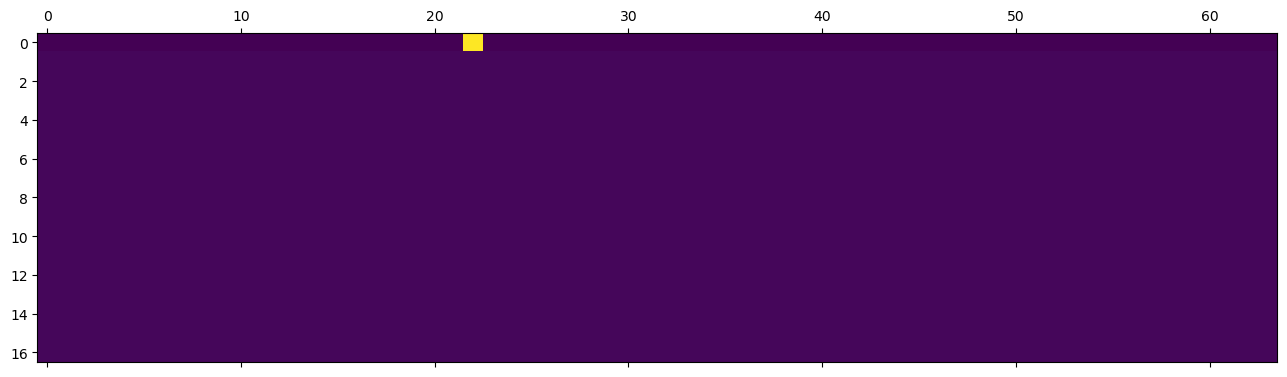

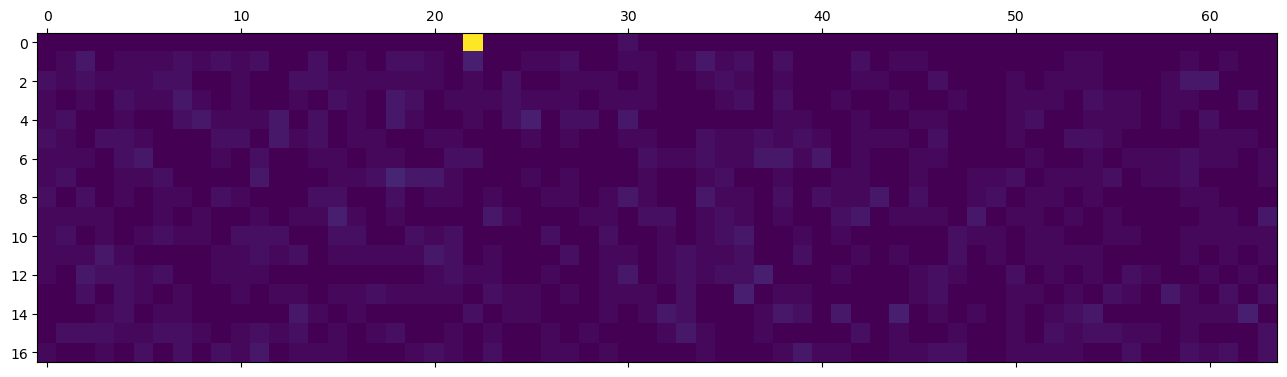

In [31]:
# compare expected and measured tomogram 
# - even though the classical fidelity is low, the tomogram look visually similar
plt.matshow(theoretical_tomogram[98])
plt.matshow(measd_tomogram_arr[98])
cl_mean_fid(theoretical_tomogram[98], measd_tomogram_arr[98])

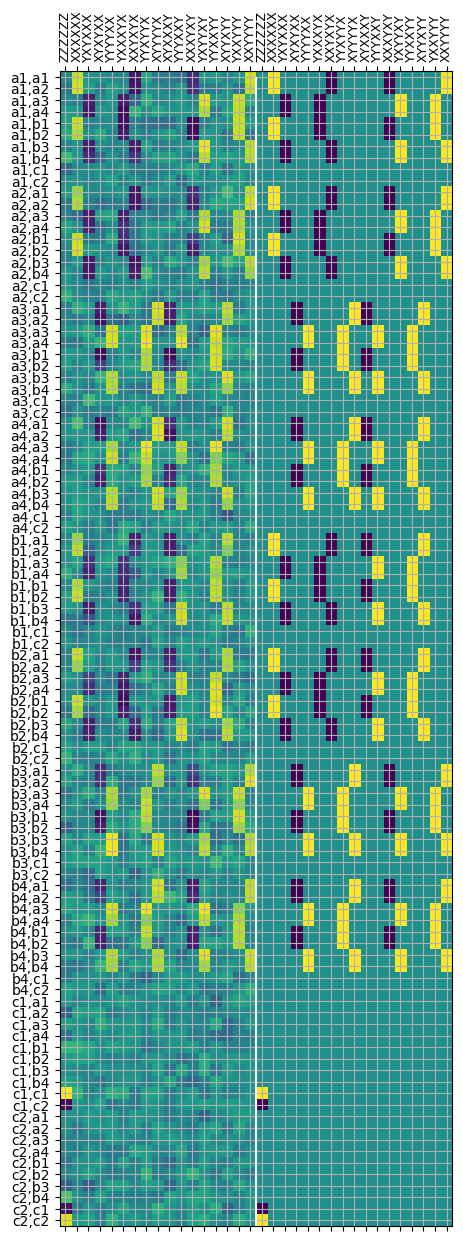

In [32]:
# Compare observed and theoretical expectation values
# for every constituent state and measurement.

expvals_measd = process_tomograms_expvals(measd_tomogram_arr)
expvals_theo = process_tomograms_expvals(theoretical_tomogram)

fig, ax = plt.subplots(1,1)
fig.set_figheight(15)

ax.matshow(np.hstack([expvals_measd,expvals_theo]))
ax.set_yticks(np.arange(100), key_order)
ax.set_xticks(np.arange(17*2), witness_measurements*2, rotation=90, fontsize=9)
ax.grid()
ax.vlines([16.5], 0, 99.5, colors='w')
plt.show()

## Part 5 - Speculation - add more noise to make it two-copy non-activable

* Noise mixing factor is increased to $q = 0.26$
* Again, positive witness value of two-copy witness do not *prove* anything, but they are at least a good indicator.

In [33]:
def process_tomograms_mod(tomos : np.ndarray, q : float) -> float:
    """
    Take a pack of tomograms and turn them into a witness value.
    Args:
        tomos (np.ndarray): Array of measured tomograms with shape (100, 17, 64),
            where 100 is the number of constituent two-copy states,
            17 is the number of measurement settings,
            and 64 is the number of outcomes per setting.
    Returns:
        float: The computed witness value from the weighted tomograms.
    """
    #weight-and-mix the constituent tomograms    
    _weights_single_copy = np.array([(1-q)/8]*8 + [q/2]*2)
    _weights_two_copy = np.outer(_weights_single_copy, _weights_single_copy).ravel()

    weighted_tomo_counts = np.sum(tomos * _weights_two_copy.reshape((100,1,1)), axis=0)
    #norm lines to identity sum - in order to convert possible count array to probabilities
    weighted_tomo_probs = weighted_tomo_counts/np.sum(weighted_tomo_counts, axis=1).reshape((17,1))
    #extend tomogram by copying the first line 16-times to...
    wtomo = extend_tomogram(weighted_tomo_probs)
    #...calculate expectation values
    expvals = np.sum(wtomo * walsh_table, axis=1)
    #turn expvals into subwitnesses and ensure trace(W)=1 (the factor 1/64)
    return (expvals @ witness_factors)/64

#fix RNG for reproducibility
RNG = np.random.default_rng(seed=20250530)
# Number of Monte Carlo samples per SNR
MONTE_CARLO_SAMPLES = 1000  
#number of shots in the original dataset
SHOTS = 50 

#renorm tomogram, to get rid of small numerical errors of oveflowing 1 in prob. sub
n_measd_tomogram_arr = measd_tomogram_arr/measd_tomogram_arr.sum(axis=2).reshape((100,17,1))

print("Generating samples...")
sampled_tomograms = RNG.multinomial(SHOTS, n_measd_tomogram_arr, (MONTE_CARLO_SAMPLES, 100, 17))
print("Processing samples...")
sampled_witness_values = np.array([process_tomograms_mod(tomo, 0.26) for tomo in tqdm(sampled_tomograms)])

Generating samples...
Processing samples...


  0%|          | 0/1000 [00:00<?, ?it/s]

5.3
max 0.003413971354166671
min 0.000648738281250001
sampled mean 0.0021349693580729194
seed value 0.002128707031249991
std 0.0003994325070061908
Fraction of positive values: 1.0


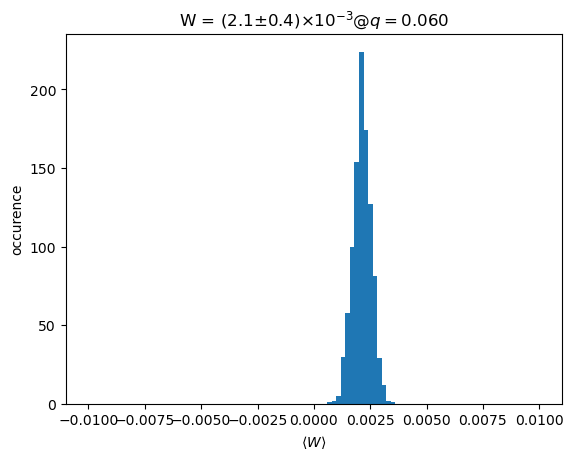

In [36]:
seed = process_tomograms_mod(n_measd_tomogram_arr, 0.26)
sigma = np.std(sampled_witness_values)
mu = np.mean(sampled_witness_values)
significance = seed/sigma
portion_above_zero = np.sum(sampled_witness_values >= 0)

print(f'{abs(significance):.1f}')
print('max', np.max(sampled_witness_values))
print('min', np.min(sampled_witness_values))
print('sampled mean', mu)
print('seed value', seed)
print('std', sigma)
print('Fraction of positive values:', portion_above_zero/MONTE_CARLO_SAMPLES)

#Plot histogram
plt.hist(sampled_witness_values, bins=np.linspace(-0.01, 0.01, 101))
plt.title(f'W = ({seed*1000:.1f}$\pm${sigma*1000:.1f})$\\times 10^{{-3}} @ q=${Q:.3f}')
plt.xlabel('$\\langle W \\rangle$')
plt.ylabel('occurence')
plt.show()

In [37]:

# Extrapolate witness table to 3 copies??
# Based on this notebook: adopt_conventions_polished.ipynb
# I created notebook extrapolate.ipynb

## Part 6 - law of error propagation

The measured data has form of 3D array $t_{kij}$ (stored in `measd_tomogram_arr`), containing relative frequencies of measurement outcomes, measured with $n$ shots. First axis ($k$) iterates over 100 constituent states (assigned weights are $w_k$, stored in `weights_two_copy` array), second axis ($i$) iterates over 32 measurements in expanded tomogram (associated witness factors are $\xi_i$, stored in `witness_factors` array), and the last (3rd) axis ($j$) iterates over 64 measurement outcomes (000000 ... 111111).

Line of the tomogram can be converted into expectation value using what I call *Walsh-Hadamard* vector (stored in `walsh_table` array), a vector with $\pm 1$ values. It depends on the measurement and it is tabulated matrix $\eta$, with components $\eta_{ij}$.

The witness value is then calculated as 

$$
\langle W \rangle = \sum\limits_{kij} \xi_{i} \eta_{ij} w_{k} t_{kij} = \sum\limits_{kij} M_{kij} t_{kij} = \vec{M} \vec{t}.
$$

In this linear form, the error propagation law is

$$
\sigma_{w}^{2} = \vec{M}^{T} \Sigma \vec{M},
$$
where $\vec{M}$ is a $M_{kij}$ matrix serialized into column vector, and $\Sigma$ is covariance matrix. We will index it with a multiindex $(k,i,j)$ and it has diagonal elements:


$$
\Sigma_{kij,kij} = t_{kij} (1-t_{kij})/n,
$$
and off-diagonal elements
$$
\Sigma_{kij,k'i'j'} = -t_{kij} t_{k'i'j'} \delta_{k k'} \delta_{i i'}/n,
$$
where $n$ is number of shots per state and measurement.

> **Note:** 
>
> count in tomo is $c_{kij} = t_{kij} n$, its variance is $n t_{kij} (1-t_{kij})$. 
> The relative frequency is estimated at $t_{kij} = c_{kij}/n$ with variance $var(c_{kij})/n^2 = t_{kij} (1-t_{kij})/n.$



In our data arrangement, the Kronecker $\delta_{i i'}$ is what actually limits the covariance. It has shape of blocks 64x64 filling the diagonal, i.e. $I_{3200} \otimes B_{64\times 64}$. The $\Sigma$ matrix is however very sparse and impractically large to be written as in the program.

The correlation are only relevant within subtomogram $t_{ki}$. The vector $\Sigma \vec{M}$ can be written as

$$
\mathrm{diag}(\Sigma) \vec{M} - \zeta,
$$
where 
$$
\zeta_{ijk} = -\frac{1}{n}\sum_{k'i'j'} t_{kij} t_{k'i'j'} \delta_{k k'} \delta_{i i'} (1-\delta_{j j'}) M_{k'i'j'}
$$
$$
\zeta_{ijk} = -\frac{1}{n}t_{kij} \sum_{j' \neq j}  t_{kij'}M_{kij'} =
-\frac{1}{n}t_{kij} \left(\sum_{j'}  t_{kij'}M_{kij'} - t_{kij}M_{kij} \right) = 
-\frac{1}{n}t_{kij} \sum_{j'}  t_{kij'}M_{kij'} + \frac{1}{n}t_{kij}^2 M_{kij} 
$$
is the correction factor.

> **Note 2**
>
> This under-estimates the uncertainty a bit, because in reality first 16 lines of the tomograms are just copies and not independent measurements. In this sense, Monte-Carlo is a bit more precise estimation at the moment. But it can be fixed by redefining M matrix as 100x17x64 matrix.
>

**Update**

It can be fixed with this choice of M matrix:
$$
M_{0jk} = \sum\limits_{i'=0}^{15} \xi_{i'} \eta_{i'j} w_{k},
$$
$$
M_{(i>0)jk} = \xi_{i+15} \eta_{i+15,j} w_{k},
$$
i.e. by replacing the first 16 $i$-lines in the matrix by its sum. Then, the above calculation can be applied as before.

In [38]:
def extend_tomograms(tomogram):
    return np.array([extend_tomogram(t) for t in tomogram])

M = witness_factors.reshape((1,32,1,)) * walsh_table.reshape((1,32,64)) * weights_two_copy.reshape((100,1,1))
Mred = np.zeros((100,17,64), dtype=np.float64)
Mred[:,0,:] = np.sum(M[:,0:16,:], axis=1)
Mred[:,1:,:] = M[:,16:,:]

def tomo_to_sigma(tomo, shots, corrs=True):    
    tvec = tomo.ravel()
    mvec = Mred.ravel()
    witval_aux = (tomo * Mred)
    witval_aux_psum = np.kron(np.sum(witval_aux, axis=2).ravel(), np.ones(64))
    witval = np.sum(witval_aux)
    
    diag_sigma = tvec * (1-tvec) / shots
    vec_aux = (diag_sigma * Mred.ravel())    
    if not corrs:
        return witval, (mvec @ vec_aux)
    #if corrs=True, add correlations into account
    pta = -(tvec * witval_aux_psum)/shots #in multinomial distribution, correlations actually reduce the overall variance
    ptb = (tvec*tvec*mvec)/shots
    vec_aux = vec_aux + pta + ptb
    return witval, (mvec @ vec_aux)
    
m, u = tomo_to_sigma(measd_tomogram_arr, 50, False)
print("Without correlations")
print(1000*m/64, '+/-', 1000*(u**0.5)/64, 'x 10^-3')

m, u = tomo_to_sigma(measd_tomogram_arr, 50, True)
print("With correlations")
print(1000*m/64, '+/-', 1000*(u**0.5)/64, 'x 10^-3')

Without correlations
-5.698220052083333 +/- 0.5411859814622135 x 10^-3
With correlations
-5.698220052083333 +/- 0.5021230404858589 x 10^-3


In [40]:
m, u = tomo_to_sigma(theoretical_tomogram, 50, False)
print("Without correlations")
print(1000*m/64, '+/-', 1000*(u**0.5)/64, 'x 10^-3')

m, u = tomo_to_sigma(theoretical_tomogram, 50, True)
print("With correlations")
print(1000*m/64, '+/-', 1000*(u**0.5)/64, 'x 10^-3')

Without correlations
-8.904166666666672 +/- 0.5453930807393061 x 10^-3
With correlations
-8.904166666666672 +/- 0.4916760735770299 x 10^-3
